In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.spatial import distance
from statistics import mean as avg

In [58]:
def get_reference_sample(points, sample_size, method = "SVD"):
    if method == 'SVD':
        return get_reference_SVD_sample(points, sample_size)
    if method == 'simple':
        return get_reference_simple_sample(points, sample_size)
    else:
        raise Exception("Reference sample method not recognized")

    return None

def get_reference_simple_sample(points, sample_size):
    
    num_features = len(points[0]) # feature vector length
    
    # 
    reference_samples = [np.zeros(num_features) for i in range(sample_size)]
    
    for f_index in range(num_features):
        
        # Get min and max for a given feature
        feature_min = min([p[f_index] for p in points])
        feature_max = max([p[f_index] for p in points])
        
        # Update the values of the reference samples at the f_ith feature
        for i in range(sample_size):
            reference_samples[i][f_index] = random.uniform(feature_min, feature_max)
            
    return reference_samples    
        

def get_reference_SVD_sample(points, sample_size):
    
    num_features = len(points[0])
    column_means_vector = np.zeros(num_features)
    
    # Create the mean vector (each value is mean of column)
    for f_index in range(num_features):
        mean = avg([p[f_index] for p in points])
        column_means_vector[f_index] = mean
    '''
    centered_points = []
    
    # centering points values
    for p in points:
        p_feat_vec = np.array(p)
        mean_vec = np.array(column_means_vector)
        
        centered_points.append(p_feat_vec - mean_vec)
       
    
    centered_matrix = np.array(centered_points)
    u,s,v = np.linalg.svd(centered_matrix)
    
    param_matrix = [list(p) for p in centered_matrix * v]
    '''
    points_matrix = np.array(points)
    mean_vector = np.zeros(num_features)
    
    u,s,v = np.linalg.svd(points_matrix)
    
    X = np.inner(points_matrix,v)
    trans_points = [list(p) for p in X]
    samples = get_reference_simple_sample(trans_points, sample_size)
    Z = np.inner(np.array(samples),np.transpose(v))
    
    samples = [list(p) for p in Z]
    
    #mean_vector = np.array(column_means_vector)
    #centered_matrix = points_matrix - mean_vector
    
    return Z


In [59]:
def init_gaussian_board(N, k):
    n = float(N)/k
    X = []
    
    for i in range(k):
        c = (random.uniform(-1, 1), random.uniform(-1, 1))
        s = random.uniform(0.05,0.5)
        x = []
        while len(x) < n:
            a, b = np.array([np.random.normal(c[0], s), np.random.normal(c[1], s)])
            # Continue drawing points from the distribution in the range [-1,1]
            if abs(a) < 1 and abs(b) < 1:
                x.append([a,b])
        X.extend(x)
    X = np.array(X)[:N]
    return X


In [60]:
test_data = init_gaussian_board(100, 4)
test_data[:10]

array([[-0.47079413,  0.25366724],
       [-0.1716479 ,  0.68651194],
       [-0.07118771,  0.78214157],
       [-0.6831478 ,  0.05379475],
       [-0.49664251,  0.4728488 ],
       [-0.74647784,  0.89647076],
       [-0.99990963,  0.57130997],
       [-0.59589136,  0.13803068],
       [-0.70432722,  0.52704565],
       [-0.14506559,  0.86273059]])

In [61]:
def get_cluster_sets(data, cluster_indexes, k):
    
    clusters = [[] for i in range(k)]
    
    for i in range(len(data)):
        clusters[cluster_indexes[i]].append(data[i])
    
    return clusters

def compute_ssq(cluster):
    ssq = 0
    for e1 in cluster:
        for e2 in cluster:
            ssq += distance.euclidean(e1, e2)
            
    return ssq

In [206]:
def compute_gap_statistic(points, k_num, B, method = 'SVD', use_SE = False):
    std_points = preprocessing.scale(points)
    kmeans = KMeans(n_clusters = k_num, max_iter = 255)
    kmeans.fit(std_points)
    
    clusters = get_cluster_sets(test_data, kmeans.labels_, k_num)
    
    # Calculating total SSQ within clusters
    nonlog_Wk = 0
    for c in clusters:
        nonlog_Wk += compute_ssq(c)
    
    
    # Check again from here on
    num_rows = len(points)
    
    reference_sample_data = []

    try:
        # Try to guess if B is matrix
        test_matrix = B[0]
        reference_sample_data = B
        groups = int(np.ceil(len(reference_sample_data[0])/num_rows))
    except:
        # Then here it's a scalar
        reference_sample_data = get_reference_sample(points, B * num_rows, method)
        groups = B

    nonlog_Wk_star = []    
    
    for i in range(groups):
        first = num_rows * (i)
        last = num_rows * (i + 1)
        
        #print('----\n First:',first)
        #print(' Last:',last,'\n----')
        
        tmp_kmeans = KMeans(n_clusters = k_num, max_iter = 255)
        tmp_kmeans.fit(reference_sample_data[first:last])
        
        tmp_cluster_labels = tmp_kmeans.labels_
        tmp_cluster_sets = get_cluster_sets(reference_sample_data[first:last], tmp_cluster_labels, k_num)
        
        tmp_nonlog_withinss = sum([compute_ssq(c) for c in tmp_cluster_sets])
        nonlog_Wk_star.append(tmp_nonlog_withinss)

    if use_SE:
        se = np.std(nonlog_Wk_star) * np.sqrt(1 + 1/(groups + 1))
        Wk_diff = np.mean(nonlog_Wk_star) - nonlog_Wk
        
        return Wk_diff, se
        
    return np.mean(nonlog_Wk_star) - nonlog_Wk, 0

In [240]:
def find_best_k(data, B, method = "SVD"):
    gap = -1
    k = 0
    p = len(data[0])
    
    reference_sample_data = get_reference_sample(data, B * p, method)
    
    gap_k_plus = compute_gap_statistic(data, k + 1, reference_sample_data, method, True)
    gap_k_plus = gap_k_plus[0]
    
    while(gap < 0):
        k = k + 1
        gap_k = gap_k_plus
        k_plus = compute_gap_statistic(data, k + 1, reference_sample_data, method, True)
        
        print(k_plus)
        gap_k_plus = k_plus[0]
        se_k_plus = k_plus[1]
        
        print('Gap k', gap_k)
        print('Gap stat k+1', gap_k_plus)
        print('Std stat k+1', se_k_plus)
        print('k', k)
        print('-----------')
        gap = gap_k - gap_k_plus + se_k_plus
            
    return(k)


Num samples:  100
p =  2

Gap statistic:  (736.3178736111727, 76.58748462439613)
(633.6529273657839, 0.0)
Gap k 183.87034699645847
Gap stat k+1 633.6529273657839
Std stat k+1 0.0
k 1
-----------
(247.05935338869529, 0.0)
Gap k 633.6529273657839
Gap stat k+1 247.05935338869529
Std stat k+1 0.0
k 2
-----------


2

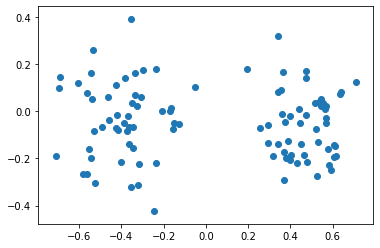

In [247]:
test_data = init_gaussian_board(100, 2)

print('Num samples: ', len(test_data))
print('p = ', len(test_data[0]))
print()
r = compute_gap_statistic(test_data, 2, 10, 'SVD', True)
plt.scatter([p[0] for p in test_data], [p[1] for p in test_data])
print("Gap statistic: ", r)

find_best_k(test_data, 1000, method = "SVD")